In [1]:
from numpy.fft import fft
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
N_data = 10  # Number of training data in final augmented dataset
L = 1024      # Length of IQ sequence in each sample
D = 100 # Decimation factor for long-term data
SNRdBmin = 90
SNRdBmax = 100

In [3]:
max_pw  = 1000 # Pulse Width (us)
max_pri = 1000 # Pulse Repetition Interval (us)
min_sig = 0.01
max_sig = 1    # Magnitude of the radar signal
SNRdBmin = 0
SNRdBmax = 20
fs = 20e6
LFM_maxBW = 10e6
LFM_minBW = 1e6
max_agility_BW = 5e6
min_agility_BW = 1e6

seq_len = 1000

In [4]:
data = np.zeros((N_data, L, 8))

# 9 columns: 
#   0: modulation (0=unmodulated, 1=linear frequency modulation) 
#   1: frequency agility (0=no agility, 1=jitter)
#   2: pulse width agility (0=no agility, 1=jitter)
#   3: pulse repetition interval agility (0=no agility,1=jitter)
#   4: minimum pulse width
#   5: maximum pulse width (same as minimum if no agility)
#   6: minimum pulse repetition interval
#   7: maximum pulse repetition interval (same as minimum if no agility)
#   8: SNR in dB
labels = np.zeros((N_data, 9)) 

for i in range(N_data):
    # Select Radar emitter parameters
    pri_min = random.uniform(0, np.log10(max_pri)) 
    pri_min = 10**pri_min
    pw_max = random.uniform(0, np.log10(min(pri_min, max_pw))) # PW needs to be less than pri, or the radar will be CW
    pw_max = 10**pw_max
    sig_mag = random.uniform(np.log10(min_sig), np.log10(max_sig))
    sig_mag = 10**sig_mag
    phase_off = random.uniform(0, 2*np.pi)

    pulse_phase = random.uniform(0, 1) # Phase between 0 and 1 as percent of cycle elapsed at start of waveform
    mod_type = random.randint(0,1) # 0 is unmodulated, 1 is LFM
    freq_agile = random.randint(0,1) # 0 is no agility, 1 is jitter
    pw_agile = random.randint(0,1) # 0 is no agility, 1 is jitter
    pri_agile = random.randint(0,1) # 0 is no agility, 1 is jitter
    freq_agility_BW = random.uniform(min_agility_BW, max_agility_BW)
    LFM_BW = random.uniform(np.log10(LFM_maxBW), np.log10(LFM_minBW))
    LFM_BW = 10**LFM_BW

    freq_seq = np.zeros(seq_len)
    freq_off_seq = np.zeros(seq_len)
    if (freq_agile == 1):
        for j in range(seq_len):
            freq_seq[j] = random.uniform(-LFM_BW/2, LFM_BW/2) # deviation of frequency from center frequency
            freq_off_seq[j] = random.uniform(0, 2*np.pi) # phase offset that varies per pulse

    pw_seq = np.zeros(seq_len)
    if (pw_agile == 1):
        pw_min = random.uniform(np.log10(1), np.log10(pw_max))
        pw_min = 10**pw_min
        for j in range(seq_len):
            pw_seq[j] = random.uniform(pw_min, pw_max) 
    else:
        pw_min = pw_max

    pri_seq = np.zeros(seq_len)
    if (pri_agile == 1):
        pri_max = random.uniform(np.log10(pri_min), np.log10(max_pri))
        pri_max = 10**pri_max
        for j in range(seq_len):
            pri_seq[j] = random.uniform(pri_min, pri_max)
    else:
        pri_max = pri_min


    t = np.linspace(0.0, (L*D-1)/fs, L*D)
    dt = t[1]-t[0]

    x_mag = np.zeros(D*L)
    x_phase = np.zeros(D*L)
    # No modulation or agility
    if (mod_type == 0) & (pw_agile == 0) & (pri_agile == 0) & (freq_agile == 0):
        x_mag = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) < (pw_min*1e-6)
        x_phase = phase_off
    # basic LFM
    elif (mod_type ==1) & (pw_agile == 0) & (pri_agile == 0) & (freq_agile == 0):
        x_mag   = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) < (pw_min*1e-6)
        x_time = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) * x_mag # This should represent the time elapsed since start of the pulse
        x_phase = np.pi*LFM_BW*(x_time**2/(pw_min*1e-6)-x_time)
    # unmod freq_agile
    elif (mod_type ==0) & (freq_agile == 1) & (pw_agile == 0) & (pri_agile == 0):
        x_mag   = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) < (pw_min*1e-6)
        x_time = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) * x_mag # This should represent the time elapsed since start of the pulse
        k = (t // (pri_min*1e-6)) # This should represent which pulse we are on
        k = k.astype(int) # Turn the floats in the array into integers so that they can be used for indexing. Lord only knows why integer division returns a float
        x_phase = 2*np.pi*freq_seq[k % seq_len]*x_time+freq_off_seq[k % seq_len]
    # LFM freq_agile
    elif (mod_type ==1) & (freq_agile == 1) & (pw_agile == 0) & (pri_agile == 0):
        x_mag   = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) < (pw_min*1e-6)
        x_time = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) * x_mag # This should represent the time elapsed since start of the pulse
        k = (t // (pri_min*1e-6)) # This should represent which pulse we are on
        k = k.astype(int)
        x_phase = np.pi*LFM_BW*(x_time**2/(pw_min*1e-6)-x_time)+2*np.pi*freq_seq[k % seq_len]*x_time+freq_off_seq[k % seq_len]
    # unmod pw_agile
    elif (mod_type == 0) & (freq_agile == 0) & (pw_agile == 1) & (pri_agile == 0):
        k = (t // (pri_min*1e-6)) # This should represent which pulse we are on
        k = k.astype(int)
        x_mag = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) < (pw_seq[k % seq_len]*1e-6)
        x_phase = phase_off
    # LFM pw_agile
    elif (mod_type == 1) & (freq_agile == 0) & (pw_agile == 1) & (pri_agile == 0):
        k = (t // (pri_min*1e-6)) # This should represent which pulse we are on
        k = k.astype(int)
        x_mag = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) < (pw_seq[k % seq_len]*1e-6)
        x_time = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) * x_mag # This should represent the time elapsed since start of the pulse
        x_phase = np.pi*LFM_BW*(x_time**2/(pw_seq[k % seq_len]*1e-6)-x_time)
    # unmod pw_agile freq_agile
    elif (mod_type == 0) & (freq_agile == 1) & (pw_agile == 1) & (pri_agile == 0):
        k = (t // (pri_min*1e-6)) # This should represent which pulse we are on
        k = k.astype(int)
        x_mag = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) < (pw_seq[k % seq_len]*1e-6)
        x_time = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) * x_mag # This should represent the time elapsed since start of the pulse
        x_phase = 2*np.pi*freq_seq[k % seq_len]*x_time+freq_off_seq[k % seq_len]
    # LFM pw_agile freq_agile
    elif (mod_type == 1) & (freq_agile == 1) & (pw_agile == 1) & (pri_agile == 0):
        k = (t // (pri_min*1e-6)) # This should represent which pulse we are on
        k = k.astype(int)
        x_mag = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) < (pw_seq[k % seq_len]*1e-6)
        x_time = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) * x_mag # This should represent the time elapsed since start of the pulse
        x_phase = np.pi*LFM_BW*(x_time**2/(pw_seq[k % seq_len]*1e-6)-x_time) + 2*np.pi*freq_seq[k % seq_len]*x_time+freq_off_seq[k % seq_len]
    # pri_agile
    elif (mod_type == 0) & (freq_agile == 0) & (pw_agile == 0) & (pri_agile == 1):
        x_time = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) # Time since start of signal
        x_time_p = np.zeros(D*L) # Time since start of pulse
        k = np.zeros(D*L,dtype=int)
        for j in range(1,D*L):
            if (x_time_p[j-1] >= 1e-6*pri_seq[k[j-1]%seq_len]):
                k[j] = k[j-1] + 1
                x_time_p[j] = 0
            else:
                k[j] = k[j-1]
                x_time_p[j] = x_time_p[j-1] + dt
        x_mag = x_time_p < (pw_min*1e-6)
        x_phase = phase_off
    # LFM pri_agile
    elif (mod_type == 1) & (freq_agile == 0) & (pw_agile == 0) & (pri_agile == 1):
        x_time = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) # Time since start of signal
        x_time_p = np.zeros(D*L) # Time since start of pulse
        k = np.zeros(D*L,dtype=int)
        for j in range(1,D*L):
            if (x_time_p[j-1] >= 1e-6*pri_seq[k[j-1]%seq_len]):
                k[j] = k[j-1] + 1
                x_time_p[j] = 0
            else:
                k[j] = k[j-1]
                x_time_p[j] = x_time_p[j-1] + dt
        x_mag = x_time_p < (pw_min*1e-6)
        x_phase = np.pi*LFM_BW*(x_time_p**2/(pw_min*1e-6)-x_time_p)
    # freq_agile pri_agile
    elif (mod_type == 0) & (freq_agile == 1) & (pw_agile == 0) & (pri_agile == 1):
        x_time = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) # Time since start of signal
        x_time_p = np.zeros(D*L) # Time since start of pulse
        k = np.zeros(D*L,dtype=int)
        for j in range(1,D*L):
            if (x_time_p[j-1] >= 1e-6*pri_seq[k[j-1]%seq_len]):
                k[j] = k[j-1] + 1
                x_time_p[j] = 0
            else:
                k[j] = k[j-1]
                x_time_p[j] = x_time_p[j-1] + dt
        x_mag = x_time_p < (pw_min*1e-6)
        x_phase = 2*np.pi*freq_seq[k % seq_len]*x_time_p+freq_off_seq[k % seq_len]
    # LFM freq_agile pri_agile
    elif (mod_type == 1) & (freq_agile == 1) & (pw_agile == 0) & (pri_agile == 1):
        x_time = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) # Time since start of signal
        x_time_p = np.zeros(D*L) # Time since start of pulse
        k = np.zeros(D*L,dtype=int)
        for j in range(1,D*L):
            if (x_time_p[j-1] >= 1e-6*pri_seq[k[j-1]%seq_len]):
                k[j] = k[j-1] + 1
                x_time_p[j] = 0
            else:
                k[j] = k[j-1]
                x_time_p[j] = x_time_p[j-1] + dt
        x_mag = x_time_p < (pw_min*1e-6)
        x_phase = np.pi*LFM_BW*(x_time_p**2/(pw_min*1e-6)-x_time_p)+2*np.pi*freq_seq[k % seq_len]*x_time_p+freq_off_seq[k % seq_len]
    # pw_agile pri_agile
    elif (mod_type == 0) & (freq_agile == 0) & (pw_agile == 1) & (pri_agile == 1):
        x_time = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) # Time since start of signal
        x_time_p = np.zeros(D*L) # Time since start of pulse
        k = np.zeros(D*L,dtype=int)
        for j in range(1,D*L):
            if (x_time_p[j-1] >= 1e-6*pri_seq[k[j-1]%seq_len]):
                k[j] = k[j-1] + 1
                x_time_p[j] = 0
            else:
                k[j] = k[j-1]
                x_time_p[j] = x_time_p[j-1] + dt
        x_mag = x_time_p < (pw_seq[k % seq_len]*1e-6)
        x_phase = phase_off
    # LFM pw_agile pri_agile
    elif (mod_type == 1) & (freq_agile == 0) & (pw_agile == 1) & (pri_agile == 1):
        x_time = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) # Time since start of signal
        x_time_p = np.zeros(D*L) # Time since start of pulse
        k = np.zeros(D*L,dtype=int)
        for j in range(1,D*L):
            if (x_time_p[j-1] >= 1e-6*pri_seq[k[j-1]%seq_len]):
                k[j] = k[j-1] + 1
                x_time_p[j] = 0
            else:
                k[j] = k[j-1]
                x_time_p[j] = x_time_p[j-1] + dt
        x_mag = x_time_p < (pw_seq[k % seq_len]*1e-6)
        x_phase = np.pi*LFM_BW*(x_time_p**2/(pw_seq[k % seq_len]*1e-6)-x_time_p)
    # freq_agile pw_agile pri_agile
    elif (mod_type == 0) & (freq_agile == 1) & (pw_agile == 1) & (pri_agile == 1):
        x_time = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) # Time since start of signal
        x_time_p = np.zeros(D*L) # Time since start of pulse
        k = np.zeros(D*L,dtype=int)
        for j in range(1,D*L):
            if (x_time_p[j-1] >= 1e-6*pri_seq[k[j-1]%seq_len]):
                k[j] = k[j-1] + 1
                x_time_p[j] = 0
            else:
                k[j] = k[j-1]
                x_time_p[j] = x_time_p[j-1] + dt
        x_mag = x_time_p < (pw_seq[k % seq_len]*1e-6)
        x_phase = 2*np.pi*freq_seq[k % seq_len]*x_time_p+freq_off_seq[k % seq_len]
    # LFM freq_agile pw_agile pri_agile
    elif (mod_type == 1) & (freq_agile == 1) & (pw_agile == 1) & (pri_agile == 1):
        x_time = ((t + pulse_phase*pri_min) % (pri_min*1e-6)) # Time since start of signal
        x_time_p = np.zeros(D*L) # Time since start of pulse
        k = np.zeros(D*L,dtype=int)
        for j in range(1,D*L):
            if (x_time_p[j-1] >= 1e-6*pri_seq[k[j-1]%seq_len]):
                k[j] = k[j-1] + 1
                x_time_p[j] = 0
            else:
                k[j] = k[j-1]
                x_time_p[j] = x_time_p[j-1] + dt
        x_mag = x_time_p < (pw_seq[k % seq_len]*1e-6)
        x_phase = np.pi*LFM_BW*(x_time_p**2/(pw_min*1e-6)-x_time_p)+2*np.pi*freq_seq[k % seq_len]*x_time_p+freq_off_seq[k % seq_len]
    

    x = x_mag*np.exp(1j*x_phase)
    x = sig_mag*x

    # Add AWGN noise with random power
    SNRdB = random.uniform(SNRdBmin, SNRdBmax)
    SNR = 10**(SNRdB/10)
    sig_pwr = np.mean(np.abs(x)**2)
    sigma2 = sig_pwr/SNR
    noise = np.random.randn(np.size(x))*np.sqrt(sigma2/2) + 1j*np.random.randn(np.size(x))*np.sqrt(sigma2/2)
    x_long = x + noise

    x_short = x_long[np.arange(0, int(np.size(x_long)/D), 1)]
    x_long = x_long[np.arange(0, np.size(x_long), D)]

    xf_short = fft(x_short)
    xf_long  = fft(x_long)


    x_ms = abs(x_short)
    x_ps = np.angle(x_short)
    x_ml = abs(x_long)
    x_pl = np.angle(x_long)
    xf_ms = abs(xf_short)
    xf_ps = np.angle(xf_short)
    xf_ml = abs(xf_long)
    xf_pl = np.angle(xf_long)

    data[i,:,0] = x_ms
    data[i,:,1] = x_ps
    data[i,:,2] = x_ml
    data[i,:,3] = x_pl
    data[i,:,4] = xf_ms
    data[i,:,5] = xf_ps
    data[i,:,6] = xf_ml
    data[i,:,7] = xf_pl

    labels[i,0] = mod_type
    labels[i,1] = freq_agile
    labels[i,2] = pw_agile
    labels[i,3] = pri_agile
    labels[i,4] = pw_min
    labels[i,5] = pw_max
    labels[i,6] = pri_min
    labels[i,7] = pri_max
    labels[i,8] = SNRdB

PW: 1.0 PRI: 1.0 Modulation 1.0
Modulation-------: 1.0
Frequency Agility: 1.0
PW Agility-------: 1.0
PRI Agility------: 1.0
Pulse Width------: 1.7480895551949827 5.151635239863813
PRI--------------: 25.29180799895924 36.827620198805725
SNRdB------------: 13.682208679698789


<function matplotlib.pyplot.show(close=None, block=None)>

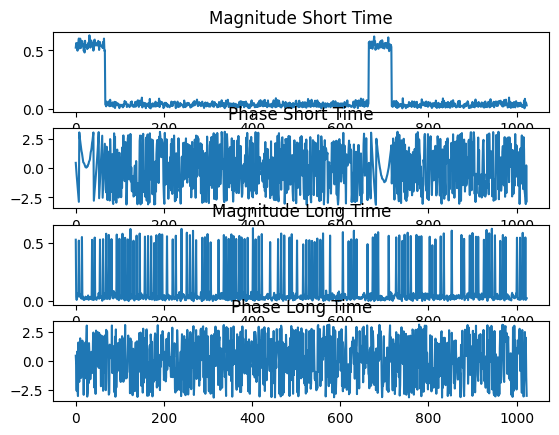

In [9]:
index = 3

print('PW:', labels[index,0], 'PRI:', labels[index,1], 'Modulation', labels[index,3])
print('Modulation-------:', labels[index,0])
print('Frequency Agility:', labels[index,1])
print('PW Agility-------:', labels[index,2])
print('PRI Agility------:', labels[index,3])
print('Pulse Width------:', labels[index,4], labels[index,5])
print('PRI--------------:', labels[index,6], labels[index,7])
print('SNRdB------------:', labels[index,8])
ax1 = plt.subplot(411)
plt.plot(data[index,:,0])
plt.title('Magnitude Short Time')
ax2 = plt.subplot(412,sharex=ax1)
plt.plot(data[index,:,1])
plt.title('Phase Short Time')
ax1 = plt.subplot(413)
plt.plot(data[index,:,2])
plt.title('Magnitude Long Time')
ax2 = plt.subplot(414,sharex=ax1)
plt.plot(data[index,:,3])
plt.title('Phase Long Time')
plt.show

In [6]:
# Save the generated training data
# data_out_name = 'data05_test_2500'
# labels_out_name = 'labels05_test_2500'
data_out_name = 'trash'
labels_out_name = 'trash'
out_file_dir  = 'training_data/'

np.save(out_file_dir+data_out_name, data)
np.save(out_file_dir+labels_out_name, labels)